In this project, I will try to optimize a simple portfolio consisting of S&P 500 Stocks using Markowitz Mean-Variance Portfolio Optimization

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import random
import seaborn as sns

#First of all, we must import the required dataframe and pivot the columns. What we are looking for as a result is a dataframes with columns 
#, each column signifying a stock while rows signify returns
df = pd.read_csv("all_stocks_5yr.csv")
display(df.head())
print(len(df))
#As we can see, there are 619040 rows
print(len(df.Name.unique()))
#Overall, expectedly, there are around 500 stocks meaning we will have to deal with around 500 columns.
display(df.head())
print(len(df))
df['date'] = pd.to_datetime(df['date'], errors='coerce')
print(df['date'].dt.year.unique())


,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


619040
505


,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


619040
[2013 2014 2015 2016 2017 2018]


In [8]:
#let's drop every information except 1st, 2nd, 3d or January and December 29th, 30th and 31st of the year. The multiple dates
#Are chosen in case a given year falls on a holiday, which would risk not registering it for the year
df["date"] = pd.to_datetime(df['date'])
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
print(df['date'].dt.year.unique())

df = df[df['day'].isin([29, 30, 31]) & df['month'].isin([1, 12])]
#We only take the last three days from december and july (semiannually)
print(len(df))
#This allowed us to reduce the number of row to process 120 times, down to 5400 (10 data points for each stock)
df = df[df['day'] == df.groupby('year')['day'].transform('max')]
print(len(df))
display(df.head())
print(df['date'].dt.year.unique())

[2013 2014 2015 2016 2017 2018]
10856
3453


,date,open,high,low,close,volume,Name,day,month,year
225,2013-12-31,24.74,25.25,24.63,25.25,7168395,AAL,31,12,2013
246,2014-01-31,33.44,34.08,33.00,33.55,12795698,AAL,31,1,2014
477,2014-12-31,53.90,54.64,53.32,53.63,11063024,AAL,31,12,2014
729,2015-12-31,42.54,42.57,41.83,42.35,6813757,AAL,31,12,2015
981,2016-12-30,47.42,47.66,46.47,46.69,4495016,AAL,30,12,2016


[2013 2014 2015 2016 2017 2018]


In [10]:
print(df.columns)
def calculate_yearly_returns(df):
    # Ensure 'close' column exists and is used properly
    if 'close' not in df.columns:
        raise KeyError("'close' column not found in DataFrame. Available columns:", df.columns)

    # Sort the dataframe to ensure it's ordered by stock name and date
    df = df.sort_values(by=['Name', 'date'])

    # Dictionary to store yearly returns for each stock
    yearly_returns = {}

    # Loop through each stock (Name) group
    for name, group in df.groupby('Name'):
        # Dictionary to store the yearly return for this stock
        stock_returns = {}

        # Group by year and get the last available prices for each year
        for year in sorted(group['year'].unique()):
            if year - 1 in group['year'].values:
                last_year_data = group[group['year'] == year - 1]
                first_price = last_year_data['close'].values[-1]  # Last price of previous year (e.g. Dec 31)
                
                current_year_data = group[group['year'] == year]
                last_price = current_year_data['close'].values[-1]  # Last price of current year (e.g. Dec 31)

                # Calculate the yearly return if both prices are greater than zero
                if first_price > 0 and last_price > 0:
                    yearly_return = (last_price / first_price) - 1
                else:
                    yearly_return = None  # Handle missing or zero prices

                # Store the result
                stock_returns[year] = yearly_return

        yearly_returns[name] = stock_returns

    # Convert the dictionary to a DataFrame
    ret_df = pd.DataFrame(yearly_returns).transpose()

    # Display the head of the DataFrame
    print("Yearly Returns DataFrame:")
    ret_df = ret_df.dropna()
    print(ret_df.head())
    
    return ret_df

# Example usage with your DataFrame
yearly_returns_df = calculate_yearly_returns(df)
print("There are " + str(sum(yearly_returns_df.isna().sum())) + " null values")
null_rows = yearly_returns_df[yearly_returns_df.isna().any(axis=1)]
print("Stocks with null values in their yearly returns:")
print(null_rows)
#The Nas have been cleared

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'Name', 'day',
       'month', 'year'],
      dtype='object')
Yearly Returns DataFrame:
          2014      2015      2016      2017      2018
A    -0.284141  0.021251  0.089691  0.074846  0.499489
AAL   1.123960 -0.210330  0.102479 -0.052260  0.227571
AAP   0.439104 -0.055060  0.123646 -0.028855 -0.287689
AAPL  0.377243 -0.046385  0.100323  0.047747  0.379728
ABBV  0.239159 -0.094743  0.057056 -0.024114  0.836361
There are 0 null values
Stocks with null values in their yearly returns:
Empty DataFrame
Columns: [2014, 2015, 2016, 2017, 2018]
Index: []


Now, let's try to pivot our dataframe, to make sure the stocks are the columns

In [12]:

def pivot_monthly_returns(df):
    print("Returns DataFrame Columns:", df.columns)
    print("Returns DataFrame Head:")
    print(df.head())
    
    df = df.reset_index().rename(columns={'index': 'Name'})
    df_melted = df.melt(id_vars='Name', var_name='Year', value_name='Return')    
    df_melted['Year'] = df_melted['Year'].astype(int)
    pivot_df = df_melted.pivot_table(index=['Year'], columns='Name', values='Return')
    print("Pivoted Monthly Returns DataFrame:")
    print(pivot_df.head())
    return pivot_df

# Create the pivoted DataFrame
yearly_returns_pivoted_df = pivot_monthly_returns(yearly_returns_df)

# Display pivoted DataFrame
display(yearly_returns_pivoted_df)

#yearly_returns_pivoted_df = yearly_returns_pivoted_df.dropna(axis = 1, how = "all")

# Check for missing values in the pivoted DataFrame
#print("Missing values in pivoted returns DataFrame (by column):")
print("There are " + str(sum(yearly_returns_pivoted_df.isna().sum())) + " null values")

# Clean the data - Option 1: Drop rows with any NaN values
#yearly_returns_pivoted_df = yearly_returns_pivoted_df.dropna(how='any')
#print(sum(yearly_returns_pivoted_df.isna().sum()))

# Proceed with portfolio optimization

Returns DataFrame Columns: Index([2014, 2015, 2016, 2017, 2018], dtype='int32')
Returns DataFrame Head:
          2014      2015      2016      2017      2018
A    -0.284141  0.021251  0.089691  0.074846  0.499489
AAL   1.123960 -0.210330  0.102479 -0.052260  0.227571
AAP   0.439104 -0.055060  0.123646 -0.028855 -0.287689
AAPL  0.377243 -0.046385  0.100323  0.047747  0.379728
ABBV  0.239159 -0.094743  0.057056 -0.024114  0.836361
Pivoted Monthly Returns DataFrame:
Name         A       AAL       AAP      AAPL      ABBV       ABC       ABT  \
Year                                                                         
2014 -0.284141  1.123960  0.439104  0.377243  0.239159  0.282321  0.174537   
2015  0.021251 -0.210330 -0.055060 -0.046385 -0.094743  0.150288 -0.002443   
2016  0.089691  0.102479  0.123646  0.100323  0.057056 -0.246071 -0.144734   
2017  0.074846 -0.052260 -0.028855  0.047747 -0.024114  0.116255  0.087477   
2018  0.499489  0.227571 -0.287689  0.379728  0.836361  0.14195

Name,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
Year,,,,,,,,,,,,,,,,,,,,,
2014,-0.284141,1.123960,0.439104,0.377243,0.239159,0.282321,0.174537,0.086232,0.214115,0.090124,...,0.079460,-0.057274,-0.086462,0.098804,0.138866,0.100289,-0.036503,0.217083,-0.048398,0.316305
2015,0.021251,-0.210330,-0.055060,-0.046385,-0.094743,0.150288,-0.002443,0.170082,0.292160,-0.003602,...,0.139948,0.085008,-0.156842,0.142294,-0.233045,-0.041240,0.002745,-0.095486,-0.042441,0.113642
2016,0.089691,0.102479,0.123646,0.100323,0.057056,-0.246071,-0.144734,0.120861,0.095912,0.312726,...,-0.049005,0.285288,0.157922,-0.051274,-0.178739,0.356712,-0.133060,0.005946,0.576557,0.117070
2017,0.074846,-0.052260,-0.028855,0.047747,-0.024114,0.116255,0.087477,-0.027832,0.101311,0.031947,...,0.008320,-0.035945,-0.070574,-0.017842,-0.206186,-0.004241,0.034739,0.146609,-0.019749,0.026340
2018,0.499489,0.227571,-0.287689,0.379728,0.836361,0.141957,0.488149,0.411258,0.761863,0.226048,...,-0.019430,0.254639,0.040648,0.072487,0.231241,0.465423,0.290859,0.074284,0.280635,0.396614


There are 0 null values


Step II. Writing a Portfolio randomizer and Portfolio optimization function

In [28]:
#first of all, let's create a covariance matrix for the table
print(yearly_returns_pivoted_df.head())
print('Create and display the covariance matrix we need for our function')
returns_cov = yearly_returns_pivoted_df.cov()
print(returns_cov.head())
print("See the number of missing values in the functon")
print(returns_cov.isna().sum())
print(returns_cov.head())


def random_portfolios(df, cov_matrix, n_portfolios=5000, rf = 0.08):
    stocks = df.columns.unique()
    #the risk-free rate is set to 8% though this can be modified
    #The number of portfolios generated is set to 5000, though it can be modified.
    # Calculate mean returns for each stock  
    mean_returns = df.mean().values  
    #The Sharpe Ratio of the portfolio is the return premium (compared to a standard), divided by the volatility (standard deviation)
    #The goal is to identify portfolios that maximize the Sharpe ratio (provide relatively best returns for their risk. 
    #Create lists to store portfolio returns and volatilities
    portfolio_returns = []
    portfolio_volatilities = []

    # Generate random portfolios
    for i in range(n_portfolios):
        # Generate random weights that sum to 1
        p_weights = np.random.random(len(stocks))
        p_weights /= np.sum(p_weights)  # Normalize weights to sum to 1

        # Calculate the expected portfolio return
        weighted_return = np.dot(p_weights, mean_returns)
        
        # Calculate the portfolio variance using the covariance matrix
        portfolio_variance = np.dot(p_weights.T, np.dot(cov_matrix, p_weights))
        
        # Calculate the portfolio volatility (standard deviation)
        portfolio_volatility = np.sqrt(portfolio_variance)
        
        portfolio_returns.append(weighted_return)
        portfolio_volatilities.append(portfolio_volatility)

    
    return portfolio_returns, portfolio_volatilities


#Generate the actual portfolios now
portfolio_returns, portfolio_volatilities = random_portfolios(yearly_returns_pivoted_df, returns_cov, 5000)
portfolio_volatilities = np.sqrt(portfolio_volatilities)
#The portfolios now have been fully generated. We have two lists including the returns and volatilities for 5000 randomly generated portfolios
#Now, it is time to plot them on a graph to see all the range we have
print(portfolio_volatilities)
len(portfolio_volatilities)

Name         A       AAL       AAP      AAPL      ABBV       ABC       ABT  \
Year                                                                         
2014 -0.284141  1.123960  0.439104  0.377243  0.239159  0.282321  0.174537   
2015  0.021251 -0.210330 -0.055060 -0.046385 -0.094743  0.150288 -0.002443   
2016  0.089691  0.102479  0.123646  0.100323  0.057056 -0.246071 -0.144734   
2017  0.074846 -0.052260 -0.028855  0.047747 -0.024114  0.116255  0.087477   
2018  0.499489  0.227571 -0.287689  0.379728  0.836361  0.141957  0.488149   

Name       ACN      ADBE       ADI  ...        XL      XLNX       XOM  \
Year                                ...                                 
2014  0.086232  0.214115  0.090124  ...  0.079460 -0.057274 -0.086462   
2015  0.170082  0.292160 -0.003602  ...  0.139948  0.085008 -0.156842   
2016  0.120861  0.095912  0.312726  ... -0.049005  0.285288  0.157922   
2017 -0.027832  0.101311  0.031947  ...  0.008320 -0.035945 -0.070574   
2018  0.411258 

5000

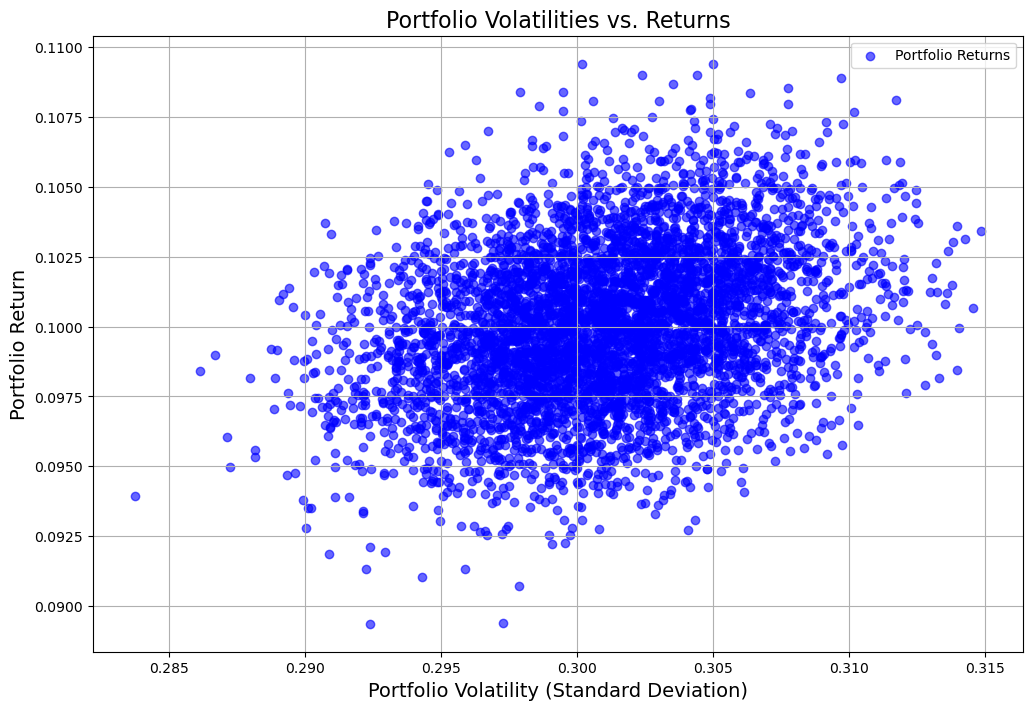

In [30]:
plt.figure(figsize=(12, 8))
plt.scatter(portfolio_volatilities, portfolio_returns, marker='o', alpha=0.6, color='blue', label="Portfolio Returns")

# Adding labels and title
plt.title('Portfolio Volatilities vs. Returns', fontsize=16)
plt.xlabel('Portfolio Volatility (Standard Deviation)', fontsize=14)
plt.ylabel('Portfolio Return', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

Step III: Finding the optimal yield curve

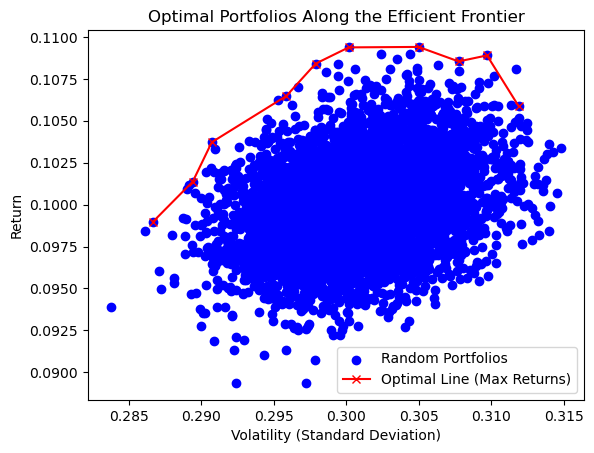

In [32]:
#The optimal portfolio curve shows the portfolio with highest return for every level of Risk. 
#Due to market imperfection, there is no mathematical sense to choose any portfolio under the line
#The issue with this, is that the volatilities are all very different, so there are probably not even two same volatilities
#A way to address this is tby taking the 10 volatility within a certain range with the best return and only displaying them

def plot_optimal_portfolio_line(portfolio_volatilities, portfolio_returns, n_volatility_buckets=10):
    portfolio_volatilities = np.array(portfolio_volatilities)
    portfolio_returns = np.array(portfolio_returns)

    min_volatility = portfolio_volatilities.min()
    max_volatility = portfolio_volatilities.max()
    volatility_ranges = np.linspace(min_volatility, max_volatility, n_volatility_buckets + 1)

    optimal_volatilities = []
    optimal_returns = []

    for i in range(n_volatility_buckets):
        mask = (portfolio_volatilities >= volatility_ranges[i]) & (portfolio_volatilities < volatility_ranges[i + 1])
        if np.any(mask):
            # Find the portfolio with the maximum return within this range
            max_return_idx = np.argmax(portfolio_returns[mask])
            optimal_volatilities.append(portfolio_volatilities[mask][max_return_idx])
            optimal_returns.append(portfolio_returns[mask][max_return_idx])

    # plot the optimal line on top of all portfolios
    plt.scatter(portfolio_volatilities, portfolio_returns, c='blue', marker='o', label='Random Portfolios')
    
    #optimal portfolios with a red line
    plt.plot(optimal_volatilities, optimal_returns, color='red', marker='x', label='Optimal Line (Max Returns)')

    plt.title('Optimal Portfolios Along the Efficient Frontier')
    plt.xlabel('Volatility (Standard Deviation)')
    plt.ylabel('Return')
    plt.legend()
    plt.show()

    return optimal_volatilities, optimal_returns

optimal_volatilities, optimal_returns = plot_optimal_portfolio_line(portfolio_volatilities, portfolio_returns, n_volatility_buckets=10)